## Import 

In [1]:
# Neural Network
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import keras

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Computer Vision
import cv2

# Graphing
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Selective Search Region Proposals
- Define the maximum number of Selective Search region proposals to be utilized for training and inference

In [2]:
# define the number of max proposals used when running selective
# search for (1) gathering training data and (2) performing inference
max_proposals = 2000
max_proposals_infer = 200

## Max Number of Positive and Negative Regions

In [3]:
# define the maximum number of positive and negative images to be
# generated from each image
max_pos = 30
max_neg = 10

## Initializing Dimension Input
- i.e. Image input

In [4]:
# initialize the input dimensions to the network
image_input = (300, 300)

# define the path to the output model
model_path = "model_3.hdf5"

# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
min_prob = 0.80

## Loading Images

In [2]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data-Images",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=2591,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 2453 images belonging to 3 classes.


In [4]:
# Image classes
image_gen.class_indices

{'Assault Rifle': 0, 'Handgun': 1, 'No Firearm': 2}

In [5]:
# Image shape
image_gen.image_shape

(300, 300, 3)

## Separating To Images and Labels

In [6]:
images, labels = next(image_gen)

In [7]:
images.shape

(2453, 300, 300, 3)

In [8]:
labels.shape

(2453, 3)

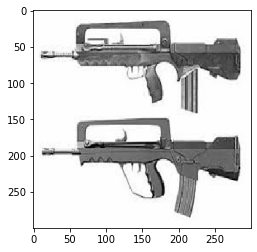

In [9]:
plt.imshow(images[0])

In [10]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), 
               (right, bottom), (right, top), 
               (left, top)], width=thickness, 
              fill=color)
    
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [11]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
        
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            
            np.copyto(image, np.array(image_pil))
            
    return image

# Apply Module

Pick an object detection module and apply on the downloaded image. Modules:

- FasterRCNN+InceptionResNet V2: high accuracy,

- ssd+mobilenet V2: small and fast.

In [12]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
# Load image
def load_img(image_num):
    img = images[image_num]
    return img

In [14]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

In [ ]:
run_detector(detector, 1)